In [1]:
import pickle
x = pickle.load(open('test.pickle', 'rb'))
n = x.shape[0]
y = x[int(n/3):,:]

In [2]:
import numpy as np
layer_thickness = np.sum(y[:,1:4],axis=1)
layer_wavespeed = (y[:,1]*y[:,5] + y[:,2]*y[:,6] + y[:,3]*y[:,7]) / np.sum(y[:,1:4],axis=1)

In [3]:
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [4]:
from scipy.stats import gaussian_kde
xy = np.vstack([layer_thickness,layer_wavespeed])
z = gaussian_kde(xy)(xy)

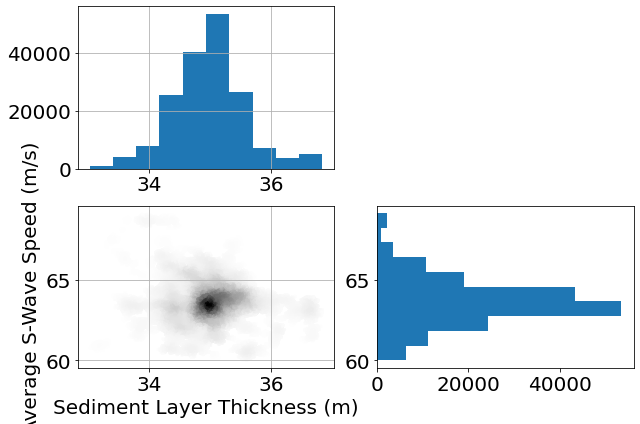

In [5]:
fig,ax=plt.subplots(2,2,figsize=(9,6))

plt.subplot(2,2,1)
plt.hist(layer_thickness)
plt.grid()

plt.subplot(2,2,2)
plt.axis('off')

plt.subplot(2,2,4)
plt.hist(layer_wavespeed, orientation="horizontal")


plt.subplot(2,2,3)
plt.scatter(layer_thickness,layer_wavespeed,c=z,s=2.5,cmap='Greys')
plt.xlabel('Sediment Layer Thickness (m)',fontsize=20)
plt.ylabel('Average S-Wave Speed (m/s)',fontsize=20)
plt.grid()
plt.tight_layout()
plt.show()

In [6]:
print(f'Initial guess: Thickness ={layer_thickness[0]}, speed = {layer_wavespeed[0]}')

Initial guess: Thickness =33.33524565784517, speed = 60.85088549429176


In [7]:
tm = np.mean(layer_thickness)
ts = np.std(layer_thickness)
print(f'Layer thickness is {tm:.1f} +/- {ts:.1f} m')

vm = np.mean(layer_wavespeed)
vs = np.std(layer_wavespeed)
print(f'Layer wavespeed is {vm:.1f} +/- {vs:.1f} m')

Layer thickness is 35.0 +/- 0.6 m
Layer wavespeed is 63.6 +/- 1.5 m


Text(0.5, 0, 'Shear Wave Speed (m/s)')

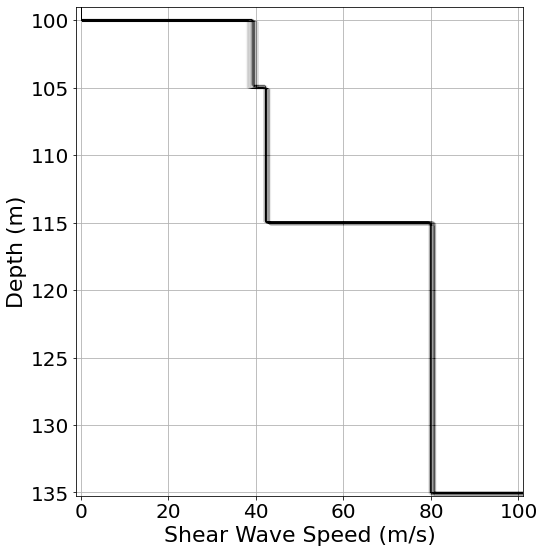

In [81]:
fig,ax=plt.subplots(figsize=(8,9))

for i,xx in enumerate(x):
    z = np.hstack([0,np.cumsum(xx[0:4])])
    vs = xx[4:9]
    plt.step(vs,z,c='Black',linewidth=0.5,label='Vs (km/s)',alpha=0.002)
    if i > 1000:
        break

plt.ylim([max(z),99])
plt.xlim([-1,101])

plt.grid()
# plt.legend(fontsize=18)
plt.ylabel('Depth (m)',fontsize=22)
plt.xlabel('Shear Wave Speed (m/s)',fontsize=22)

In [66]:
z

array([  0.        , 100.03756708, 105.32200023, 115.69372558,
       135.71319729])